# Importing libraries

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
pd.options.display.float_format = '{:.5f}'.format
import scipy 
%matplotlib inline
import math
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [86]:
df = pd.read_csv('train.csv', parse_dates = ['Datetime'])

# Data Visualisation

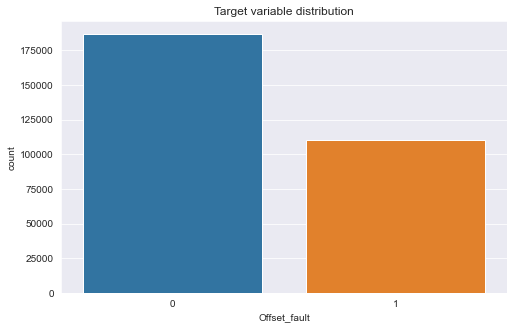

In [87]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(df["Offset_fault"])
plt.title('Target variable distribution')
plt.show()

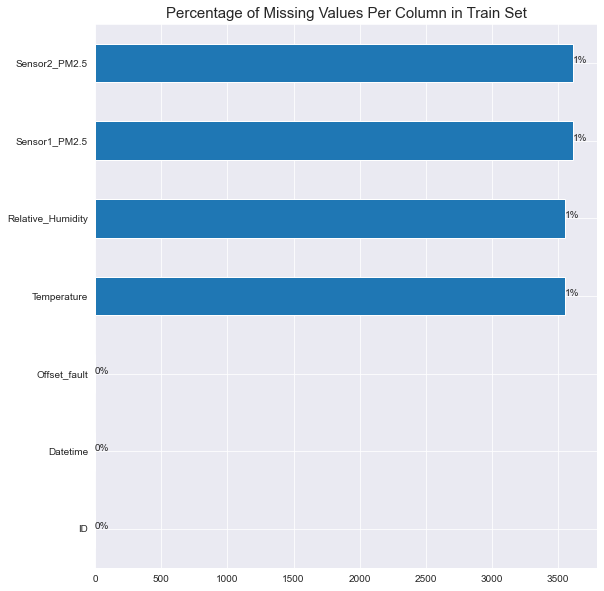

In [88]:
# Plot missing values in train set
ax = df.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

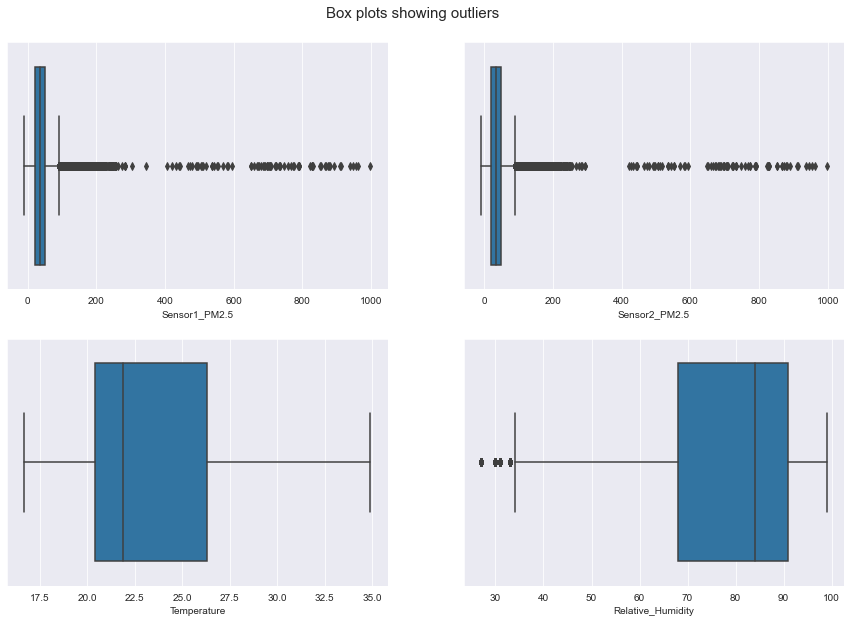

In [89]:
# Plotting boxplots for each of the numerical columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), df, ['Sensor1_PM2.5','Sensor2_PM2.5','Temperature','Relative_Humidity']):
    sns.boxplot(df[name], ax = ax)

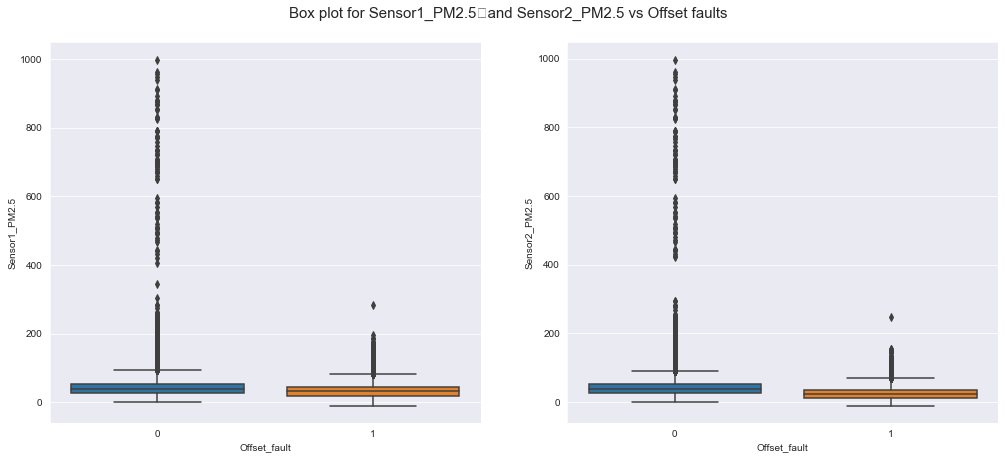

In [90]:
# Box plots for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
fig.suptitle('Box plot for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults', y= 0.95, fontsize = 15)

for ax, data, name in zip(axes.flatten(), df, ['Sensor1_PM2.5', 'Sensor2_PM2.5']):
    sns.boxplot(df.Offset_fault, df[name], ax= ax)

# Data Processing

In [92]:
def process(df):
    time_col = 'Datetime'
    df["year"] = df[time_col].dt.year
    df["month"] = df[time_col].dt.month
    df["day"] = df[time_col].dt.day
    df["hour"] = df[time_col].dt.hour
    df["minute"] = df[time_col].dt.minute
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["year"] = df[time_col].dt.year
    #df['weekend'] = df[time_col].dt.dayofweek.apply(lambda x: 1 if (x>4)  else 0)
    df['quarter'] = df[time_col].dt.quarter
    df['woy'] = df[time_col].dt.weekofyear
    #df['H'] = (df['Sensor1_PM2.5']-df['Sensor2_PM2.5'])/df['Relative_Humidity'].mean()
    df['H'] = (df['Sensor1_PM2.5']-df['Sensor2_PM2.5'])/df['Relative_Humidity'].mean()
    moy_S2= df.groupby(['Relative_Humidity'])['Sensor2_PM2.5'].mean()
    df['Relative_Humidity_M']=df[['Relative_Humidity']].replace(moy_S2.to_dict())
    df['Diff_S']=df['Sensor2_PM2.5']-df['Relative_Humidity_M']
    #df["H"] = df["Sensor1_PM2.5"]-df["Sensor2_PM2.5"]
    df.drop(columns= ['ID','Datetime','Temperature'],inplace=True)
   
    return df
    

In [97]:
df = pd.read_csv('train.csv', parse_dates = ['Datetime'])
df = process(df)
y = df['Offset_fault']
X = df.drop(columns=['Offset_fault'])
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.3, random_state=2)

In [98]:
df

,Sensor1_PM2.5,Sensor2_PM2.5,Relative_Humidity,Offset_fault,year,month,day,hour,minute,dayofweek,quarter,woy,H,Relative_Humidity_M,Diff_S
0,52.58000,49.52000,96.00000,0,2021,11,3,4,6,2,4,44,0.03890,47.85495,1.66505
1,35.25000,33.40000,75.00000,0,2021,11,8,18,43,0,4,45,0.02352,35.88161,-2.48161
2,19.18000,23.50000,75.00000,0,2021,11,7,9,50,6,4,44,-0.05492,35.88161,-12.38161
3,19.40000,15.48000,70.00000,0,2022,1,1,18,55,5,1,52,0.04984,31.20712,-15.72712
4,38.30000,34.77000,89.00000,0,2021,11,5,22,23,4,4,44,0.04488,42.07596,-7.30596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297172,36.40000,37.77000,62.00000,0,2021,11,19,12,32,4,4,46,-0.01742,27.08413,10.68587
297173,50.12000,40.63000,86.00000,1,2021,11,22,1,22,0,4,47,0.12066,47.29406,-6.66406
297174,53.68000,45.23000,94.00000,1,2021,11,5,1,27,4,4,44,0.10743,46.97753,-1.74753
297175,96.45000,114.67000,93.00000,0,2021,11,23,22,9,1,4,47,-0.23165,51.20221,63.46779


# Correlations - EDA

<Figure size 1440x864 with 0 Axes>

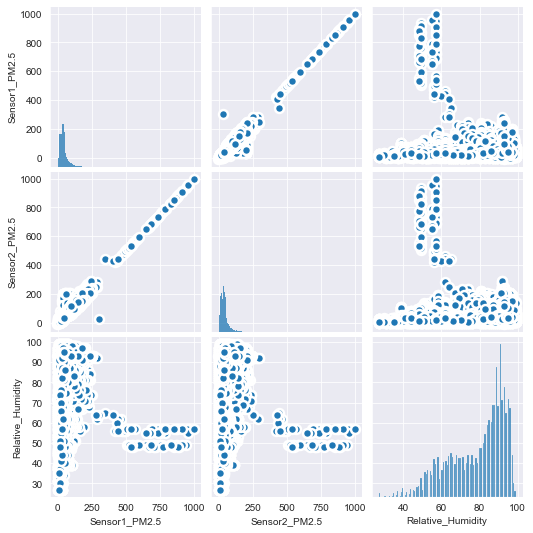

In [99]:
# Type of correlations 
plt.figure(figsize = (20, 12))
num_cols = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Relative_Humidity']
sns.pairplot(df[num_cols], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

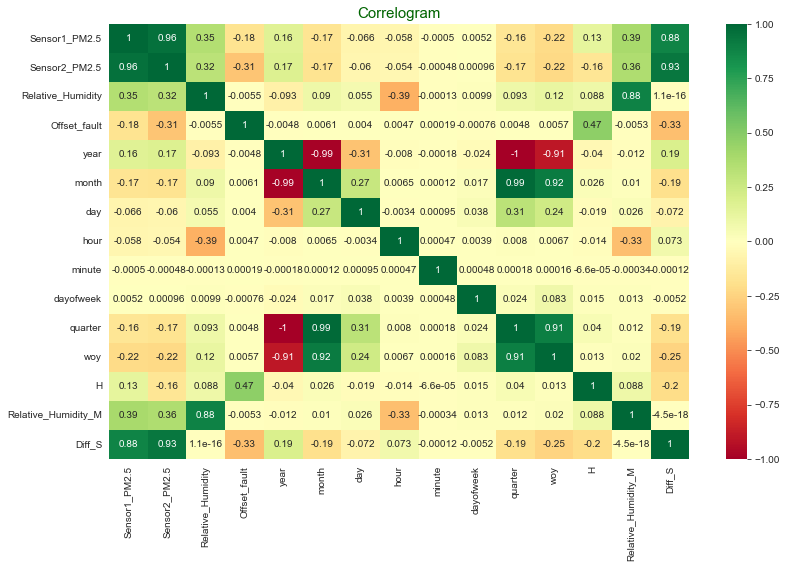

In [100]:
# Quantify correlations
corr = df.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

# Modeling

In [101]:
params = {
    'boosting_type':'dart',
    'objective':'binary',
    'max_bin':180,
    'learning_rate':0.05, #0.01 changed this
    'num_boost_round':2000,
     'num_leaves':31,
    'bagging_fraction':0.7,
    'max_depth':15,
    #'subsample_for_bin':300000,
    
}

In [102]:
from lightgbm import LGBMClassifier
lgb_model = LGBMClassifier(boosting_type=params['boosting_type'],objective=params['objective'],num_boost_round=params['num_boost_round'] 
,learning_rate=params['learning_rate'],num_leaves=params['num_leaves'],max_bin=params['max_bin'],max_depth=params['max_depth'])
lgb_model.fit(X_train, y_train)

# Making predictions
y_pred = lgb_model.predict(X_test)

[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


# Scoring 

In [103]:
# Measuring the accuracy of the model
def evaluate(test,predictions):
    print(f'Accuracy score: {accuracy_score(test, predictions)}')
    print('\n')
    print(f'{classification_report(test, predictions)}')

In [104]:
evaluate(y_test,y_pred)

Accuracy score: 0.9621665881508401


              precision    recall  f1-score   support

           0       0.97      0.97      0.97     56003
           1       0.95      0.95      0.95     33151

    accuracy                           0.96     89154
   macro avg       0.96      0.96      0.96     89154
weighted avg       0.96      0.96      0.96     89154



# Feature selection

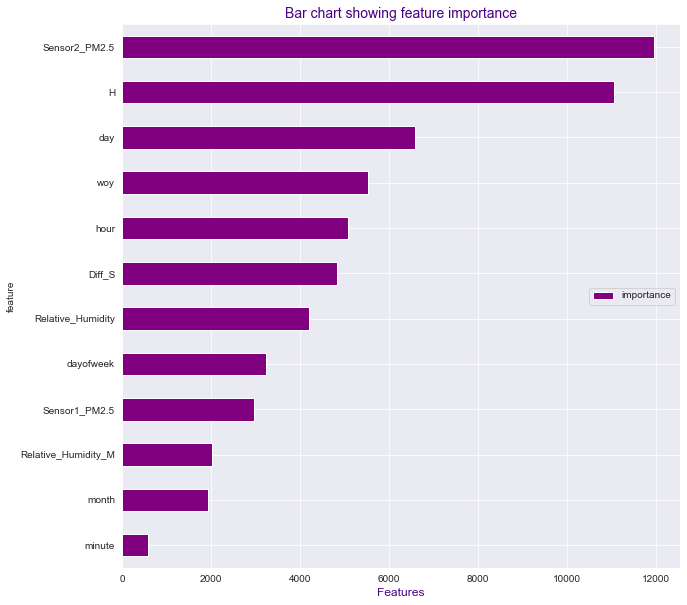

In [106]:
impo_df = pd.DataFrame({'feature': X.columns, 'importance': lgb_model.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

# Submission

In [105]:
ss = pd.read_csv('SampleSubmission.csv')
df_test = pd.read_csv('test.csv', parse_dates = ['Datetime'])
test = process(df_test)
ss['Offset_fault'] = lgb_model.predict(test)
version = 'Finalwinner.csv'
ss.to_csv(version, index=False)